This is part of the CTR prediction project. Here, I build wide and deep model by pytorch. 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import IterableDataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import math
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('drive/My Drive/20210401/CTR/filtered_train.csv')

# df = pd.read_csv('drive/My Drive/20210401/CTR/train_full.csv')
# df_test = pd.read_csv('drive/My Drive/20210401/CTR/test_full.csv')

In [ ]:
#train_dset.columns.tolist().index('click')

In [ ]:
df['hr'] = df['hour'].astype(str).str.slice(6, 8).astype(int)
df = df.iloc[: , 1:]
df = df.drop('id', axis = 1)

In [ ]:
df['hr-app_category'] = df['hr'].astype(str) + df['app_category']
df['hr-site_category'] = df['hr'].astype(str) + df['site_category']
df['hr-device_type'] = df['hr'].astype(str) + df['device_type'].astype(str)
df['banner_pos-device_type'] = df['banner_pos'].astype(str) + df['device_type'].astype(str)
df['device_type-app_category'] = df['device_type'].astype(str) + df['app_category']
df['device_type-site_category'] = df['device_type'].astype(str) + df['site_category']

In [ ]:
df.columns

Index(['click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hr',
       'hr-app_category', 'hr-site_category', 'hr-device_type',
       'banner_pos-device_type', 'device_type-app_category',
       'device_type-site_category'],
      dtype='object')

In [ ]:
df.tail()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hr,hr-app_category,hr-site_category,hr-device_type,banner_pos-device_type,device_type-app_category,device_type-site_category
404285,1,14103023,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,07f3354c,1f0bc64f,1,0,23161,320,50,2667,0,47,-1,221,23,23f95efa07,2350e219e0,231,01,1f95efa07,150e219e0
404286,0,14103020,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,2eeea4d3,28570f08,1,0,23160,320,50,2667,0,47,-1,221,20,20f95efa07,2050e219e0,201,01,1f95efa07,150e219e0
404287,0,14103021,1002,0,c545a354,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,cc1cb523,5da89a35,373ecbe6,0,0,23861,320,50,2735,2,35,100148,251,21,2107d7df22,2150e219e0,210,00,007d7df22,050e219e0
404288,0,14103021,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,0f2161f8,a99f214a,0f0f2dba,d6e0e6ff,1,0,23016,320,50,2658,3,35,100148,23,21,210f2161f8,2150e219e0,211,01,10f2161f8,150e219e0
404289,1,14103022,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,e6ff6a10,ca136f4e,1,0,19015,300,250,2162,2,39,100060,33,22,2207d7df22,223e814130,221,01,107d7df22,13e814130


In [ ]:
df.nunique()

click                             2
hour                            240
C1                                7
banner_pos                        7
site_id                        2225
site_domain                    2188
site_category                    22
app_id                         2241
app_domain                      143
app_category                     27
device_id                     64742
device_ip                    261706
device_model                   4380
device_type                       4
device_conn_type                  4
C14                            2088
C15                               8
C16                               9
C17                             411
C18                               4
C19                              65
C20                             161
C21                              60
hr                               24
hr-app_category                 408
hr-site_category                377
hr-device_type                   96
banner_pos-device_type      

In [ ]:
df = df.drop(columns=(['device_ip','device_id']))

In [ ]:
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda'
print(device)

cuda ready...
cuda


In [ ]:
obj_features = list(df.select_dtypes(['object']).columns)
int_features = list(df.select_dtypes(['int64']).columns)
int_features.remove('click')

df[obj_features] = df[obj_features].fillna('-1', )
df[int_features] = df[int_features].fillna(0, )

for feat in obj_features:
    lbe = LabelEncoder()
    df[feat] = lbe.fit_transform(df[feat])

In [ ]:
df.tail()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hr,hr-app_category,hr-site_category,hr-device_type,banner_pos-device_type,device_type-app_category,device_type-site_category
404285,1,14103023,1005,0,1150,1694,5,1369,21,25,518,1,0,23161,320,50,2667,0,47,-1,221,23,276,243,63,1,26,6
404286,0,14103020,1005,0,1150,1694,5,1369,21,25,686,1,0,23160,320,50,2667,0,47,-1,221,20,228,199,50,1,26,6
404287,0,14103021,1002,0,1701,1694,5,2060,63,0,943,0,0,23861,320,50,2735,2,35,100148,251,21,231,215,54,0,0,0
404288,0,14103021,1005,0,1150,1694,5,1982,51,4,3681,1,0,23016,320,50,2658,3,35,100148,23,21,233,215,55,1,5,6
404289,1,14103022,1005,0,811,1034,3,2060,63,0,3433,1,0,19015,300,250,2162,2,39,100060,33,22,245,228,59,1,1,4


In [ ]:
df.nunique()

click                           2
hour                          240
C1                              7
banner_pos                      7
site_id                      2225
site_domain                  2188
site_category                  22
app_id                       2241
app_domain                    143
app_category                   27
device_model                 4380
device_type                     4
device_conn_type                4
C14                          2088
C15                             8
C16                             9
C17                           411
C18                             4
C19                            65
C20                           161
C21                            60
hr                             24
hr-app_category               408
hr-site_category              377
hr-device_type                 96
banner_pos-device_type         12
device_type-app_category       48
device_type-site_category      26
dtype: int64

In [ ]:
sparse_features = df.loc[:, df.nunique() <= 100].columns.tolist()
sparse_features.remove('click')

for feat in sparse_features:
  df_temp = pd.get_dummies(df[feat], prefix=[feat])
  df = df.drop(feat, axis=1)
  df = pd.concat([df, df_temp], axis=1)


In [ ]:
# generate input data for model
train, test = train_test_split(df, test_size=0.2, random_state=2022)
# train = DataLoader(train_raw)
# test = DataLoader(test_raw)

In [ ]:
EMBEDDING_INPUTS = [
           'device_modelSEP4380SEP256',
           'app_idSEP2241SEP256',
           'site_idSEP2225SEP256',
           'site_domainSEP2188SEP256',
           'app_domainSEP143SEP128',
          ]
EMBEDDING_INPUTS1 = [
           'device_model',
           'app_id',
           'site_id',
           'site_domain',
           'app_domain',
          ]
WIDE_DIM = 423

In [ ]:
# build model

class Model(nn.Module):
    def __init__(self, wide_dim, embedding_inputs, hidden_layers, dropout_p=0.7):
        super().__init__()
        self.wide_dim = wide_dim
        self.embedding_inputs = embedding_inputs
        self.deep_feature_dim = 0
        self.hidden_layers = hidden_layers
        
        # For each deep feature, create an embedding layer to convert them to embeddings
        for embedding_input in self.embedding_inputs:
            col_name, vocab_size, embed_dim = embedding_input.split('SEP')
            #print(col_name, vocab_size, embed_dim)
            setattr(self, col_name+'_emb_layer', nn.Embedding(int(vocab_size), int(embed_dim)))
            self.deep_feature_dim += int(embed_dim)
        
        # A series of hidden layers that take the embeddings as input
        self.linear_layer_1 = nn.Linear(self.deep_feature_dim, self.hidden_layers[0])
        self.bn_1 = nn.BatchNorm1d(self.hidden_layers[0])
        for i, hidden_layer in enumerate(self.hidden_layers[1:]):
            setattr(self, f'linear_layer_{i+2}', nn.Linear(self.hidden_layers[i], hidden_layer))
        
        self.dropout = nn.Dropout(p=0.7)
        
        # Final dense layer that combine the wide features and the deep features and generate output
        self.fc = nn.Linear(self.wide_dim+self.hidden_layers[-1], 1)
        
    
    def forward(self, X_w, X_d):
        embeddings = [getattr(self, col_name+'_emb_layer')(X_d[:, i].long())
                      for i, embedding_input in enumerate(self.embedding_inputs)
                      for col_name in embedding_input.split('SEP')
                      if not col_name.isdigit()
                     ]
        
        deep_out = torch.cat(embeddings, dim=-1) # concatenate the embeddings of all deep features
        
        for i, _ in enumerate(self.hidden_layers):
            deep_out = F.relu(getattr(self, f'linear_layer_{i+1}')(deep_out))
        
        X_w = self.dropout(X_w) # Apply a dropout layer to the wide features for regularization purposes
        fc_input = torch.cat([X_w, deep_out], dim=-1) # concatenate the wide and processed deep features
        out = self.fc(fc_input)
        
        return out

In [ ]:
model = Model(wide_dim=WIDE_DIM, embedding_inputs=EMBEDDING_INPUTS, hidden_layers=[512, 256, 128], dropout_p=0.7)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

best_val_loss = float('inf')
train_losses = []
val_losses = []

# training
X_w_train = torch.tensor(train.iloc[:, 12:].values.astype(np.float32))
X_w_train = X_w_train.squeeze().to(device)
X_d_train = torch.tensor(train.iloc[:][EMBEDDING_INPUTS1].values.astype(np.float32))
X_d_train = X_d_train.squeeze().to(device)
label_train = torch.tensor(train['click'].values.astype(np.float32)).to(device)
label_train = label_train.squeeze().unsqueeze(1).to(device)

# testing
X_w_test = torch.tensor(test.iloc[:, 12:].values.astype(np.float32))
X_w_test = X_w_test.squeeze().to(device)
X_d_test = torch.tensor(test.iloc[:][EMBEDDING_INPUTS1].values.astype(np.float32))
X_d_test = X_d_test.squeeze().to(device)
label_test = torch.tensor(test['click'].values.astype(np.float32)).to(device)
label_test = label_test.squeeze().unsqueeze(1).to(device)

for epoch in range(100):


    y_pred_train = model(X_w_train,X_d_train)
    loss_train = loss_fn(y_pred_train, label_train)

    optimizer.zero_grad()
    scaler.scale(loss_train).backward()
    scaler.step(optimizer)
    scaler.update()

    print(f'=============== Epoch {epoch} ===============')
    print('epoch:', epoch, 'Training Loss:', loss_train.item())

    y_pred_test = model(X_w_test,X_d_test)
    loss_test = loss_fn(y_pred_test, label_test)
    print('epoch:', epoch, 'testing Loss:', loss_test.item())

    train_losses.append(loss_train.item())
    val_losses.append(loss_test.item())

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1] 
        # print('Best model saved.\n')
        # torch.save(model.state_dict(), './saved_model.pt')


=============== Epoch 0 ===============
epoch: 0 Training Loss: 0.7456137537956238
epoch: 0 testing Loss: 0.6631526947021484
Best model saved.

=============== Epoch 1 ===============
epoch: 1 Training Loss: 0.6633955836296082
epoch: 1 testing Loss: 0.5580483078956604
Best model saved.

=============== Epoch 2 ===============
epoch: 2 Training Loss: 0.5585184097290039
epoch: 2 testing Loss: 0.4687773287296295
Best model saved.

=============== Epoch 3 ===============
epoch: 3 Training Loss: 0.46875834465026855
epoch: 3 testing Loss: 0.4963850975036621
=============== Epoch 4 ===============
epoch: 4 Training Loss: 0.4967873692512512
epoch: 4 testing Loss: 0.5110759735107422
=============== Epoch 5 ===============
epoch: 5 Training Loss: 0.5118165016174316
epoch: 5 testing Loss: 0.4770458936691284
=============== Epoch 6 ===============
epoch: 6 Training Loss: 0.47816479206085205
epoch: 6 testing Loss: 0.4501323699951172
Best model saved.

=============== Epoch 7 ===============
epoch: 

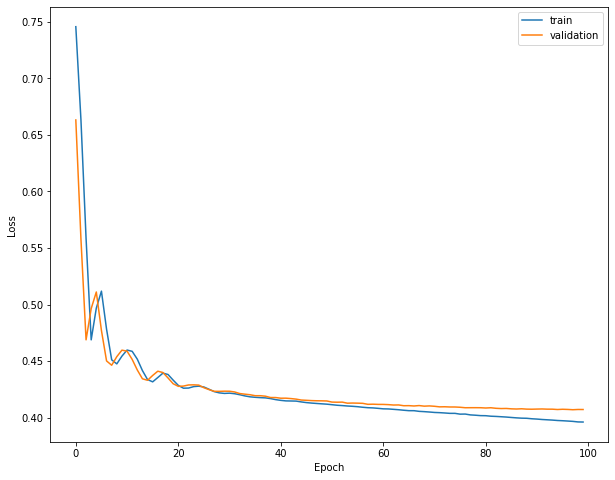

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()